In [2]:
import os
import json

from Bio.SeqIO import QualityIO
import numpy as np
# import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pandas as pd
from functions_ import *
from plotting import *
from Bio import SeqIO
from Bio.Seq import Seq
from characterization_from_blast_alignments import *
from collections import Counter

In [1]:
amplicon_AraCLOV2 = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'
start_LOV2  = "ttagccacaa".upper() ## LOV2 start # set region of interest, that has to be included in the reads to be considered for the analysis, e.g. LOV2 start site
end_LOV2 = "cggccaaa".upper() ## LOV2 end



ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}


genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


In [48]:
### get enrichment 
Folder = "/home/student/anna/DMS_analysis/output/RL8/blast/R1/enrichments/Codons/" 
enrichment = pd.read_csv(f"{Folder}/RL8_BC1_S1_R1_roiTrue_Codons_enrichment_relative.csv", index_col = 0)
mut_spectrum_codons_perc = pd.read_csv(f"{Folder}/RL8_BC1_S1_R1_roiTrue_Codons_mut_spec.csv", index_col = 0)

In [49]:

## filtering of mutagenic spectrum for plotting 
ref_len = len(enrichment.columns) * 3 ## Nts instead of codons
ref_len = ref_len + amplicon_AraCLOV2.index(start_LOV2) ## include start of LOV2

ref_codons = [amplicon_AraCLOV2[i:i+3] for i in range(0,ref_len, 3)]

pref_codons = sorted(ecoli_pref.values())



## order the mutagenic spectrum according to the pref codons and filter for the reference codons
mut_spec_perc_ordered = pd.concat((mut_spectrum_codons_perc.loc[:,pref_codons], mut_spectrum_codons_perc.loc[:,[codon for codon in codons if codon not in pref_codons]]),axis = 1)
mut_spec_perc_ordered = mut_spec_perc_ordered.loc[[codon for codon in codons if codon in ref_codons],:]
mut_spec_perc_ordered = mut_spec_perc_ordered.reindex(sorted(mut_spec_perc_ordered.index), axis=0)

## find codons that are included in (non-targeted) AraC but not in (targeted) LOV sequence
## find start position of LOV2 in seq
LOVstart = amplicon_AraCLOV2.index(start_LOV2)
AraC_codons = [amplicon_AraCLOV2[i:i+3] for i in range(0, LOVstart, 3)] # AraC codons
LOV_codons = [amplicon_AraCLOV2[i:i+3] for i in range(LOVstart, ref_len, 3)] # LOV codons
## filter codons that are only in AraC but not LOV2 seq
AraC_spec_codons = [codon for codon in AraC_codons if codon not in LOV_codons]

## count occs 
counter_LOV = Counter(LOV_codons)
for codon in mut_spec_perc_ordered.index:
    if codon not in counter_LOV:
        counter_LOV[codon] = 0
## sort after key
        
counter_LOV = dict(sorted(counter_LOV.items()))
### annotations: 
col_annot = ["grey" if codon in pref_codons else "lightgrey" for codon in mut_spec_perc_ordered.columns]
row_annot_vals = list(counter_LOV.values())
# convert row_annot to colors of cmap


cmap = plt.get_cmap('Oranges')
norm = plt.Normalize(min(row_annot_vals), max(row_annot_vals))
row_annot = [cmap(norm(value)) for value in row_annot_vals]

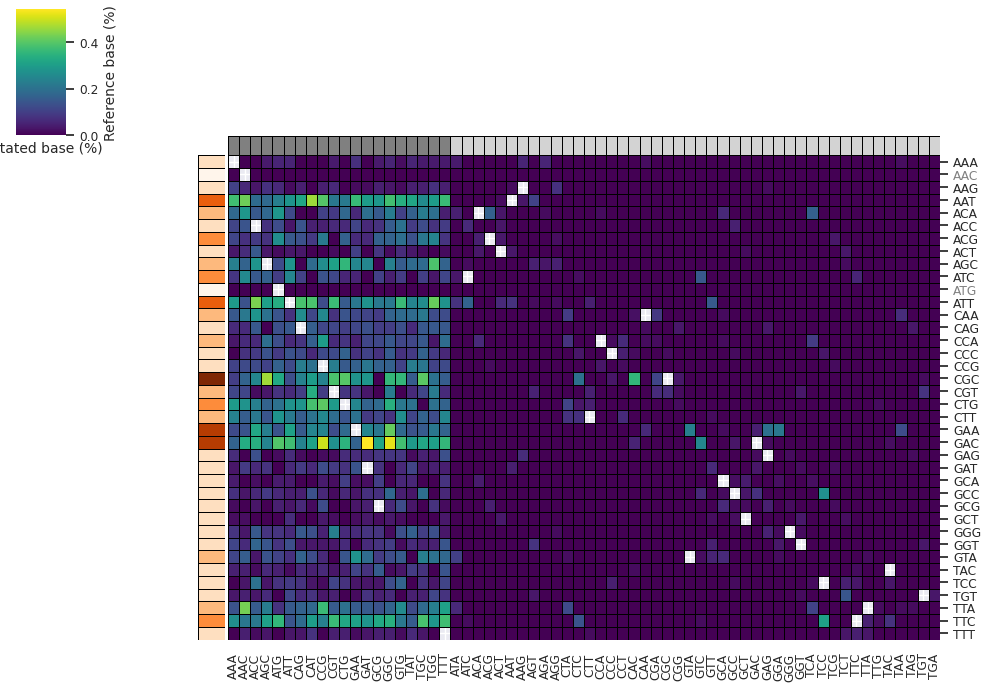

In [51]:
######### not normalized but rows annotated 
sns.set(font_scale=0.8)
g = sns.clustermap(mut_spec_perc_ordered, annot=False, linewidths=.5,  figsize = (10,7), linecolor = "black", cmap = "viridis", cbar_kws={'shrink': 0.3},  xticklabels=True,col_cluster = False, row_cluster = False,  row_colors=row_annot, col_colors=col_annot, yticklabels = True)

plt.xlabel('Mutated base (%)', fontsize = 10)
plt.ylabel('Reference base (%)', fontsize = 10)
for i, tick_label in enumerate(g.ax_heatmap.axes.get_yticklabels()):
    if tick_label.get_text() not in LOV_codons:
        tick_label.set_color('grey')

# plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{Folder}/Codons_mutagenic_spectrum_perc_ordered_Annot.pdf", bbox_inches="tight")
plt.savefig(f"{Folder}/Codons_mutagenic_spectrum_perc_ordered_Annot.png", bbox_inches="tight")

plt.show()

## AA level

In [209]:
### get enrichment 
Folder = "/home/student/anna/DMS_analysis/output/DP6/blast/combined/enrichments/AA/" 
mut_spectrum_AA_perc = pd.read_csv(f"{Folder}/DP6_BC1_S1_combined_roiTrue_AA_mut_spec.csv", index_col = 0)

In [210]:
mut_spectrum_AA_perc

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,*
A,NaN,0.000000,1.457392,1.227634,0.000000,0.064216,0.000000,0.015339,0.000000,0.000000,...,0.000000,0.017485,0.000000,0.000000,1.998999,2.911982,3.194785,0.000000,0.000000,0.000000
C,0.051607,NaN,0.000000,0.000000,0.034405,0.034405,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.103214,0.017202,0.000000,0.000000,0.017202,0.292439,0.068809
D,0.165046,0.000000,NaN,1.046675,0.000000,0.930022,0.069803,0.000000,0.000000,0.000000,...,3.092553,0.000000,0.000000,0.000000,0.000000,0.000000,0.619413,0.000000,1.737428,0.000000
E,0.200803,0.000000,1.725067,NaN,0.000000,1.527081,0.000000,0.000000,2.977696,0.000000,...,0.000000,0.000000,0.210817,0.000000,0.000000,0.000000,0.496858,0.000000,0.000000,1.545114
F,0.000000,0.249004,0.000000,0.000000,NaN,0.000000,0.000000,0.418248,0.000000,2.102779,...,0.000000,0.000000,0.000000,0.000000,0.877559,0.000000,0.177503,0.000000,0.535939,0.000000
G,0.016435,0.272943,1.456580,0.397826,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.674004,0.982725,0.000000,0.649104,0.105227,0.000000,0.058610
H,0.000000,0.000000,0.076765,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.073564,...,1.003533,0.036782,0.175123,0.153530,0.000000,0.000000,0.000000,0.000000,0.893187,0.000000
I,0.000000,0.000000,0.000000,0.000000,0.636722,0.000000,0.000000,NaN,0.000000,0.198607,...,0.386514,0.016303,0.000000,0.016015,0.468753,0.877162,1.026456,0.000000,0.000000,0.000000
K,0.000000,0.000000,0.000000,0.906613,0.000000,0.000000,0.000000,0.246452,NaN,0.000000,...,0.956693,0.000000,0.031779,1.188305,0.000000,0.120163,0.000000,0.000000,0.000000,0.555262
L,0.000000,0.000000,0.000000,0.000000,1.408831,0.016309,0.036152,0.939957,0.015738,NaN,...,0.000000,0.798659,0.099968,0.017324,0.584358,0.000000,0.164391,0.000000,0.000000,0.214092


In [211]:
LOV2_AAs = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"

In [212]:

## count occs
counter_LOV = Counter(LOV2_AAs)
for codon in mut_spectrum_AA_perc.index:
    if codon not in counter_LOV:
        counter_LOV[codon] = 0
## sort after key but with "*" at the end
counter_LOV = dict(sorted(counter_LOV.items(), key = lambda x: x[0] if x[0] != "*" else "Z"))
### annotations: 

row_annot_vals = list(counter_LOV.values())
# convert row_annot to colors of cmap


cmap = plt.get_cmap('Oranges')
norm = plt.Normalize(min(row_annot_vals), max(row_annot_vals))
row_annot = [cmap(norm(value)) for value in row_annot_vals]

In [213]:
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar  # Import colorbar module

/tmp/ipykernel_3505739/2070852273.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reversed_cmap = cm.get_cmap("Oranges").reversed()


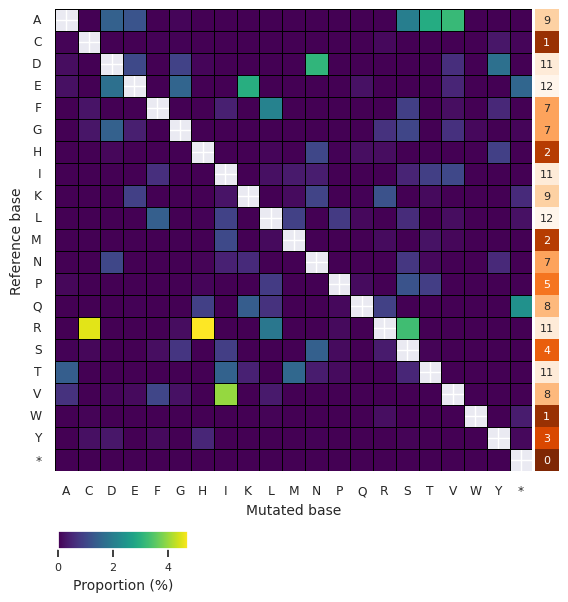

In [215]:
######### not normalized but rows annotated 
sns.set(font_scale=0.8)
fig, axes = plt.subplots(1, 2, figsize=(6.5, 6), gridspec_kw={"width_ratios": [4, 0.2]})
fig.subplots_adjust(wspace=0.01)

sns.heatmap(mut_spectrum_AA_perc, annot=False, linecolor = "black", cmap = "viridis",  xticklabels=True,yticklabels = True, ax=axes[0], cbar = False, linewidths=.5)
reversed_cmap = cm.get_cmap("Oranges").reversed()
sns.heatmap(pd.DataFrame(row_annot_vals), cmap=reversed_cmap, annot=True, 
            xticklabels=False, yticklabels=True, ax=axes[1], annot_kws={"size": 8}, cbar=False)

# Adjust layout
axes[1].set_yticks([])  # Remove yticks from annotation column
axes[1].set_ylabel("") 


axes[0].set_xlabel('Mutated base', fontsize = 10)
axes[0].set_ylabel('Reference base', fontsize = 10)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# plt.title(f"{name} mutagenic spectrum", fontsize = 12)
plt.savefig(f"{Folder}/AAs_mutagenic_spectrum_perc_ordered_Annot.pdf", bbox_inches="tight")
plt.savefig(f"{Folder}/AAs_mutagenic_spectrum_perc_ordered_Annot.png", bbox_inches="tight")

cbar_ax = fig.add_axes([0.13, -0.02, 0.2, 0.03])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("Proportion (%)", fontsize = 10)
cbar.ax.tick_params(labelsize=8)

# cbar_ax2 = fig.add_axes([0.4, -0.02, 0.3, 0.03])  # Position the second colorbar
# norm = mcolors.BoundaryNorm(boundaries=np.arange(0.5, np.max(row_annot_vals)+1.5, 1), ncolors=cmap.N)

# cbar2 = mcolorbar.ColorbarBase(cbar_ax2, cmap="Reds", norm=norm, 
#                                orientation="horizontal", ticks=np.arange(1, np.max(row_annot_vals)+1,1))

# cbar2.set_label("Annotation Value", fontsize=10)
# cbar2.ax.tick_params(labelsize=8)
plt.savefig(f"{Folder}/AAs_mutagenic_spectrum_perc_ordered_Annot.pdf", bbox_inches="tight")
plt.show()